## Computer Vision作业

In [37]:
import matplotlib.pyplot as plt # plt 用于显示图片
import cv2 as cv # mpimg 用于读取图片
import numpy as np

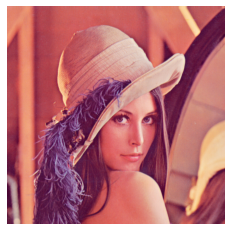

In [2]:
lena = cv.imread('lena.jpg') # 读取和代码处于同一目录下的 lena.png
lena = cv.cvtColor(lena,cv.COLOR_BGR2RGB)
plt.imshow(lena)
plt.axis("off")
plt.show()

## 1.1 基于opencv使用卷积操作对图像做模糊、锐化操作

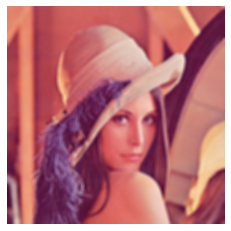

In [5]:
# tips：自定义卷积核，使用cv.filter2D对图像进行卷积操作。调整卷积核从而得到模糊效果
# code:
kernel=np.ones((9,9))/81
avg_filtered=cv.filter2D(lena,-1,kernel=kernel)
# plt.imsave('lena_2.jpg',avg_filtered)
plt.imshow(avg_filtered)
plt.axis('off')
plt.show()

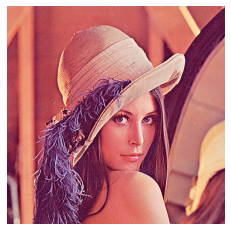

In [6]:
# tips：锐化操作
# code:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
sharp_filtered=cv.filter2D(lena,-1,kernel=kernel)
# plt.imsave('lena_1.jpg',avg_filtered)
plt.imshow(sharp_filtered)
plt.axis('off')
plt.show()

## 1.2 任意选择两种常见噪声对lena图片进行处理

各种不同噪声可以参考https://blog.csdn.net/weixin_40446557/article/details/81451651

In [33]:
def sp_noise(image,p_s=0.1):
    p_p=1-p_s
    output=image.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            for k in range(output.shape[2]):
                judge=np.random.random()
                if judge<p_s:
                    output[i][j][k]=255
                elif judge>p_p:
                    output[i][j][k]=0
    return output

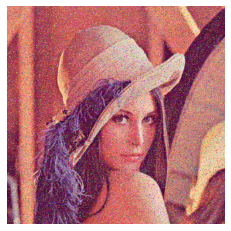

In [8]:
lena_sp_noise=sp_noise(lena,0.05)
plt.imshow(lena_sp_noise)
plt.axis('off')
plt.show()

In [83]:
def gauss_noise(image,mean=0,var=5000):
    image = np.array(image, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    output = image + noise
    output = np.clip(output,0, 255)
    output = np.uint8(output)
    return output


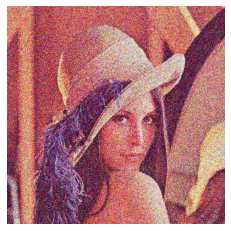

In [12]:
plt.imshow(gauss_noise(lena))
plt.axis('off')
plt.show()

## 2 使用角点检测算法对lena的灰度图进行处理并可视化结果
角点检测可以用cv库的函数实现，具体见https://blog.csdn.net/duanyajun987/article/details/82256409?utm_medium=distribute.pc_relevant.none-task-blog-baidujs_title-1&spm=1001.2101.3001.4242

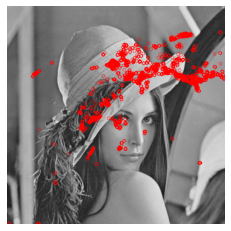

In [97]:
# tips: 角点检测算法可用Shi-Tomasi/Harris 
# 在角点处画圆，半径为4，红色，线宽默认，利于显示
# codes:
lena_gray=cv.cvtColor(lena,cv.COLOR_RGB2GRAY)
dst=cv.cornerHarris(np.float32(lena_gray),2,3,0.04)
lena_corner=cv.cvtColor(lena_gray,cv.COLOR_GRAY2RGB)

for i in range(512):
    for j in range(512):
        if dst[i][j]>0.01*dst.max():
            cv.circle(lena_corner,(i,j),4,(255,0,0))

plt.imshow(lena_corner)
plt.axis('off')
plt.show()

## 3 图像分类

针对sklearn自带的人脸数据集的识别任务，利用HOG特征作为图像的特征描述符进行分类

提示：最终提取的特征描述符维度过大，需要考虑用PCA降维后再训练分类器

### 3.1 读取图像数据

In [1]:
import cv2
import numpy as np
import sklearn
from sklearn import datasets

faces = sklearn.datasets.fetch_olivetti_faces(download_if_missing=True)
imgs = faces.images
labels = faces.target

print(imgs.shape)
print(labels.shape)

(400, 64, 64)
(400,)


### 3.2 提取图像特征描述符

hog特征描述符的说明可以参考：https://blog.csdn.net/zouxy09/article/details/7929348

提示：cv库处理时要求图像格式为np.uint8，请大家注意预处理

In [2]:
# HOG特征
# hog_descriptors 为提取得到的图像hog特征
# code:
winSize = (64,64)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (8,8)
nbins = 9

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

hog_descriptors=[]
for img in imgs:
    hog_descriptors.append(hog.compute(np.uint8(img*255)).reshape(-1))

hog_descriptors=np.array(hog_descriptors)
print(hog_descriptors.shape)

(400, 2025)


### 3.3 分类结果

In [31]:
# 需将特征改为需要使用的特征
# 利用SVM或者其他算法进行分类，分类结果展示为下个cell的形式
# 提示：可以使用sklearn库实现分类和结果展示，提供的分类结果只是形式上的展示，请大家参考
# code:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

pca=PCA(n_components=20)
pca.fit(hog_descriptors)
hog_pca=pca.transform(hog_descriptors)

hog_train, hog_test, label_train, label_test = train_test_split(hog_pca, labels, train_size = 0.6)

clf=svm.SVC()
clf.fit(hog_train,label_train)
print(clf.score(hog_test,label_test))
label_predict=clf.predict(hog_test)

mat=confusion_matrix(label_test,label_predict)
print(mat)

0.875
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 2 ... 0 0 2]]


<AxesSubplot:>

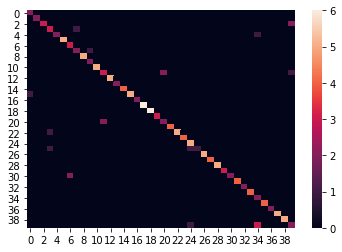

In [32]:
import seaborn as sns
sns.heatmap(mat.T)

```py
# 分类结果
[[56  1  0  0  0  0  0  0  0  0]
 [ 0 48  1  0  0  0  0  0  0  0]
 [ 0  0 49  0  1  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  1  0 40  0  1  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  1  0  1  0  0 58  0  2]
 [ 0  0  0  2  0  1  1  0 52  1]
 [ 0  1  0  2  1  0  0  3  0 44]]
***********************************
Precision:   0.958
Recall:      0.958
F1 score:    0.958
```

## 4 附加题目
完成上面的1-3题即可得到全部基础分，第4部分为附加题，内容会有部分超纲，完成会有额外加分

### 4.1 设计合理的噪声或变换，使得在人眼观感差别不大的情况下（至少可以轻松识别分类）对hog特征的分类算法产生较明显的负面影响。（+1分）

### 4.2 在要求1的基础上，设计合理的补充特征，避免要求1加入的噪声带来的负面影响并说明设计思路。（+1分）